### The previous notebook was starting to get muddled, so I am creating a new one with the correct order:
     * dynamically winsorize data w moving average
     * optimize model hyperparameters 
     * compare to previous results

In [1]:
import sys
sys.path.append("/Users/shaneypeterson/Desktop/2024.06.27_-_Data_Science/Modules")

In [2]:
import stocks as st
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly
from plotly import graph_objs as go
import streamlit
import timeit

In [3]:
st = st.Stocks()

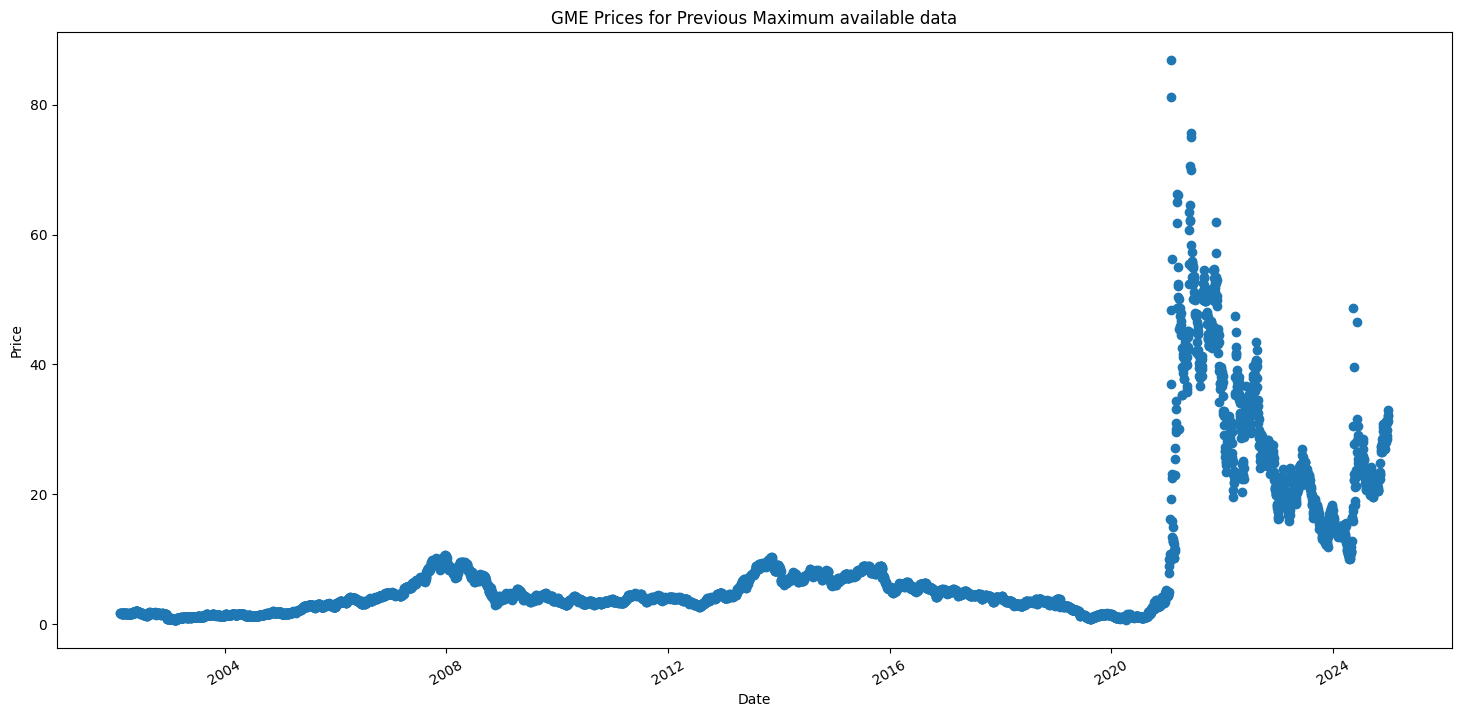

Closing price as of 2024-12-31: $31.34
The percentage change over previous Maximum available data is 1834%
Dividends total $2.39
Stock Splits total $6.0
'Capital Gains' not found in data


In [4]:
df = st.stats_generator('gme')

In [5]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2002-02-13 00:00:00-05:00,1.620128,1.693350,1.603296,1.691666,76216000,0.0,0.0
1,2002-02-14 00:00:00-05:00,1.712707,1.716074,1.670626,1.683250,11021600,0.0,0.0
2,2002-02-15 00:00:00-05:00,1.683251,1.687459,1.658002,1.674834,8389600,0.0,0.0
3,2002-02-19 00:00:00-05:00,1.666418,1.666418,1.578048,1.607504,7410400,0.0,0.0
4,2002-02-20 00:00:00-05:00,1.615920,1.662210,1.603296,1.662210,6892800,0.0,0.0


In [6]:
# remove timezone
import pandas as pd

df['Date'] = pd.to_datetime(df['Date']).dt.date

In [7]:
def dynamic_winsorize(df, column, window_size=30, percentiles=(0.05, 0.95)):
    """
    Winsorizes data within a rolling window.

    Args:
        df: DataFrame containing the data.
        column: Name of the column to winsorize.
        window_size: Size of the rolling window.
        percentiles: Tuple containing the lower and upper percentiles.

    Returns:
        DataFrame with the winsorized column.
    """

    df['rolling_lower'] = df[column].rolling(window=window_size).quantile(percentiles[0])
    df['rolling_upper'] = df[column].rolling(window=window_size).quantile(percentiles[1])

    df['winsorized'] = df[column]
    df.loc[df[column] < df['rolling_lower'], 'winsorized'] = df['rolling_lower']
    df.loc[df[column] > df['rolling_upper'], 'winsorized'] = df['rolling_upper']

    return df

# Apply dynamic winsorization
df = dynamic_winsorize(df, 'Close')

In [8]:
df[df['Close'] != df['winsorized']].head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,rolling_lower,rolling_upper,winsorized
32,2002-04-02,1.599088,1.599088,1.544383,1.568790,2098400,0.0,0.0,1.571062,1.77604,1.571062
33,2002-04-03,1.569631,1.582255,1.551957,1.565423,567200,0.0,0.0,1.566938,1.77604,1.566938
35,2002-04-05,1.594880,1.632753,1.556165,1.556165,837600,0.0,0.0,1.560331,1.77604,1.560331
36,2002-04-08,1.565423,1.565423,1.495568,1.540174,1558400,0.0,0.0,1.547370,1.77604,1.547370
40,2002-04-12,1.569631,1.569631,1.519975,1.535966,1236000,0.0,0.0,1.537859,1.77604,1.537859


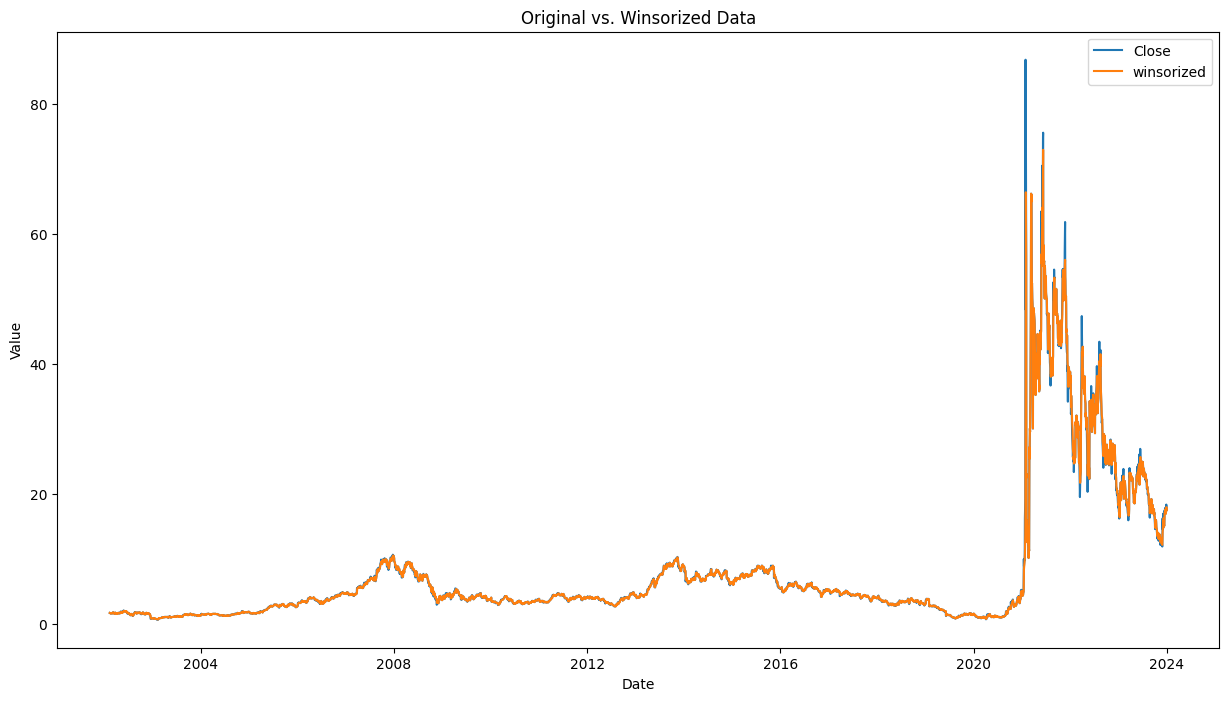

In [9]:
# zoomed view

import matplotlib.pyplot as plt
from datetime import date

# Define the desired date range
start_date = date(year=2002, month=1, day=1)
end_date = date(year=2023, month=12, day=31)

# Filter the DataFrame based on the date range
df_filtered = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

fig, ax = plt.subplots(figsize=(15, 8))

# Plot 'y' and 'winsorized_data' on the same graph
df_filtered.plot(x='Date', y=['Close', 'winsorized'], ax=ax)

# Customize the plot (optional)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original vs. Winsorized Data')
plt.legend()

# Show the plot
plt.show()

### -- create a new baseline model --


In [10]:
# format new dataset for model with 'ds' and 'y'

df_train = df[['Date' ,'Close', 'winsorized']]
df_train = df_train.rename(columns={'Date': 'ds', 'winsorized': 'y'})

In [11]:
# create function for model accuracy

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def get_model_accuracy(y_column, forecast):
    # Extract actual and predicted values without forecasted period
    y_true = y_column[-period:]
    y_pred = forecast['yhat'][-period:]

    # Calculate accuracy metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    # Create a DataFrame for the metrics
    metrics_df = pd.DataFrame({
        'Mean Absolute Error': mae,
        'Mean Absolute Percentage Error': mape,
        'Mean Squared Error': mse,
        'Root Mean Squared Error': rmse
        },
        index=[0])
    
    return metrics_df

In [12]:
%%time

period=365

m = Prophet()
m.fit(df_train)
future = m.make_future_dataframe(periods=period)
forecast = m.predict(future)

14:42:52 - cmdstanpy - INFO - Chain [1] start processing
14:42:53 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 525 ms, sys: 105 ms, total: 631 ms
Wall time: 1.58 s


In [13]:
get_model_accuracy(df_train.Close, forecast)

,Mean Absolute Error,Mean Absolute Percentage Error,Mean Squared Error,Root Mean Squared Error
0,9.533848,0.611151,116.902824,10.812161


In [14]:
m.params

OrderedDict([('lp__', array([[10408.3]])),
             ('k', array([[0.215992]])),
             ('m', array([[0.00872938]])),
             ('delta',
              array([[ 2.10742e-08, -1.25923e-07,  6.17300e-04,  1.82148e-01,
                       1.89478e-07, -3.04938e-07, -4.90697e-07, -6.48740e-01,
                      -2.84332e-06, -8.29842e-08,  3.80074e-02,  3.80127e-01,
                       9.81445e-02,  7.22362e-03, -1.73813e-07, -2.64542e-02,
                      -9.31366e-02, -5.34813e-01, -3.05529e-04, -1.55450e-07,
                       4.16110e-07,  4.47452e-07,  1.81728e+00,  3.65051e+00,
                      -4.44427e+00]])),
             ('sigma_obs', array([[0.0955223]])),
             ('beta',
              array([[-1.06138e-03, -1.09336e-02, -3.25080e-03, -4.11623e-04,
                      -2.20003e-03, -2.24701e-03, -3.45377e-03,  1.03321e-03,
                       3.13757e-03,  6.49036e-05,  7.18296e-04, -1.79909e-03,
                      -6.07102e-04, 

In [14]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
6120,2025-12-27,29.621676,20.065933,38.132245,28.576496,30.849828,-0.181989,-0.181989,-0.181989,0.608491,0.608491,0.608491,-0.790480,-0.790480,-0.790480,0.0,0.0,0.0,29.439687
6121,2025-12-28,29.627304,21.038057,38.735818,28.579590,30.860289,-0.222488,-0.222488,-0.222488,0.608491,0.608491,0.608491,-0.830979,-0.830979,-0.830979,0.0,0.0,0.0,29.404817
6122,2025-12-29,29.632933,19.856771,37.756742,28.582683,30.870612,-1.149188,-1.149188,-1.149188,-0.275831,-0.275831,-0.275831,-0.873357,-0.873357,-0.873357,0.0,0.0,0.0,28.483745
6123,2025-12-30,29.638562,19.510403,37.600392,28.585777,30.879993,-1.168167,-1.168167,-1.168167,-0.251077,-0.251077,-0.251077,-0.917090,-0.917090,-0.917090,0.0,0.0,0.0,28.470395
6124,2025-12-31,29.644191,19.070947,37.434515,28.587764,30.892959,-1.191089,-1.191089,-1.191089,-0.229505,-0.229505,-0.229505,-0.961585,-0.961585,-0.961585,0.0,0.0,0.0,28.453101


### -- for fun, i want to compare yhat with actual Close now --

In [15]:
forecast['actual_close'] = df.Close

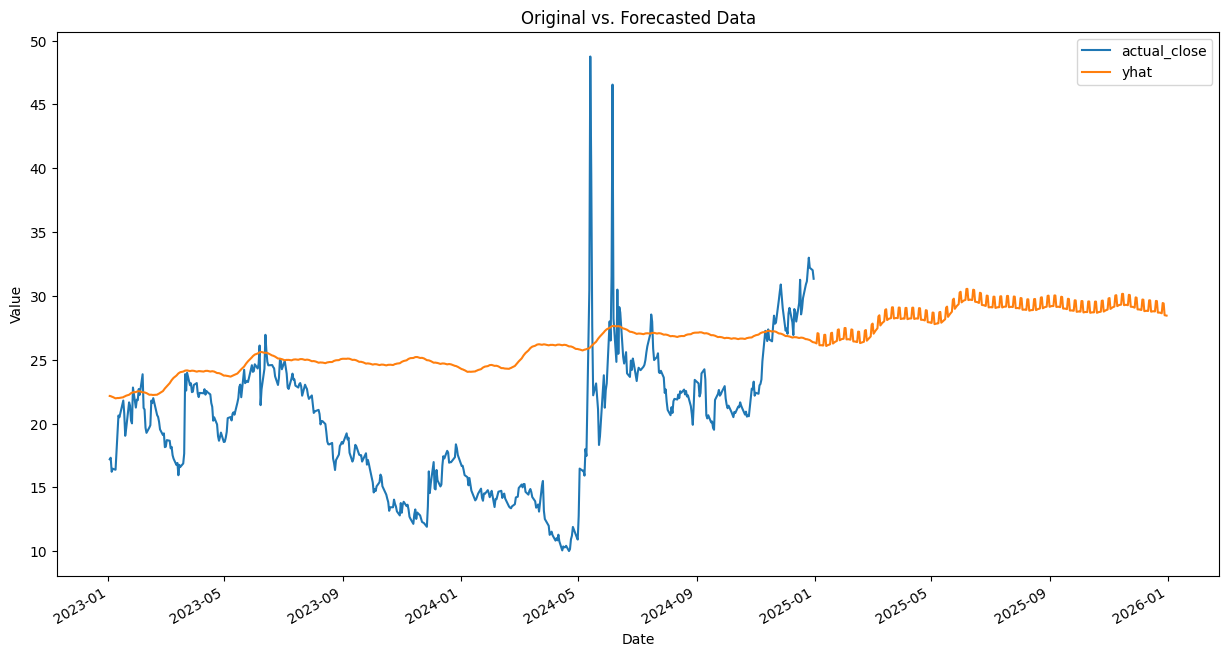

In [16]:
# Define the desired date range
start_date = date(year=2023, month=1, day=1)
end_date = date(year=2025, month=12, day=31)

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Filter the DataFrame based on the date range
df_filtered = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]

fig, ax = plt.subplots(figsize=(15, 8))

# Plot 'y' and 'winsorized_data' on the same graph
df_filtered.plot(x='ds', y=['actual_close', 'yhat'], ax=ax)

# Customize the plot (optional)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original vs. Forecasted Data')
plt.legend()

# Show the plot
plt.show()

### -- Cross Validation w Grid Search --

In [17]:
%%time
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Define hyperparameter grid
param_grid = {
    'seasonality_mode': ['multiplicative', 'additive'],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5], 
    'seasonality_prior_scale': [0.1, 1, 10] 
}

best_params = None
best_score = float('inf') 

for seasonality_mode in param_grid['seasonality_mode']:
    for changepoint_prior_scale in param_grid['changepoint_prior_scale']:
        for seasonality_prior_scale in param_grid['seasonality_prior_scale']:
            # Create and fit the model
            m = Prophet(
                seasonality_mode=seasonality_mode,
                changepoint_prior_scale=changepoint_prior_scale,
                seasonality_prior_scale=seasonality_prior_scale
            )
        m.fit(df_train)
        df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days') 
        df_p = performance_metrics(df_cv)
        score = df_p['rmse'].mean() 

        if score < best_score:
            best_score = score
            best_params = {
                'seasonality_mode': seasonality_mode,
                'changepoint_prior_scale': changepoint_prior_scale,
                'seasonality_prior_scale': seasonality_prior_scale
                        }

17:58:55 - cmdstanpy - INFO - Chain [1] start processing
17:58:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/41 [00:00<?, ?it/s]

17:58:56 - cmdstanpy - INFO - Chain [1] start processing
17:58:56 - cmdstanpy - INFO - Chain [1] done processing
17:58:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:56 - cmdstanpy - INFO - Chain [1] start processing
17:58:57 - cmdstanpy - INFO - Chain [1] done processing
17:58:57 - cmdstanpy - INFO - Chain [1] start processing
17:58:57 - cmdstanpy - INFO - Chain [1] done processing
17:58:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:57 - cmdstanpy - INFO - Chain [1] start processing
17:58:58 - cmdstanpy - INFO - Chain [1] done processing
17:58:58 - cmdstanpy - INFO - Chain [1] start processing
17:58:58 - cmdstanpy - INFO - Chain [1] done processing
17:58:58 - cmdstanpy - INFO - Chain [1] start processing
17:58:58 - cmdstanpy - INFO - Chain [1] done processing
17:58:58 -

  0%|          | 0/41 [00:00<?, ?it/s]

17:59:12 - cmdstanpy - INFO - Chain [1] start processing
17:59:12 - cmdstanpy - INFO - Chain [1] done processing
17:59:12 - cmdstanpy - INFO - Chain [1] start processing
17:59:12 - cmdstanpy - INFO - Chain [1] done processing
17:59:12 - cmdstanpy - INFO - Chain [1] start processing
17:59:12 - cmdstanpy - INFO - Chain [1] done processing
17:59:12 - cmdstanpy - INFO - Chain [1] start processing
17:59:12 - cmdstanpy - INFO - Chain [1] done processing
17:59:12 - cmdstanpy - INFO - Chain [1] start processing
17:59:13 - cmdstanpy - INFO - Chain [1] done processing
17:59:13 - cmdstanpy - INFO - Chain [1] start processing
17:59:13 - cmdstanpy - INFO - Chain [1] done processing
17:59:13 - cmdstanpy - INFO - Chain [1] start processing
17:59:13 - cmdstanpy - INFO - Chain [1] done processing
17:59:13 - cmdstanpy - INFO - Chain [1] start processing
17:59:14 - cmdstanpy - INFO - Chain [1] done processing
17:59:14 - cmdstanpy - INFO - Chain [1] start processing
17:59:15 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/41 [00:00<?, ?it/s]

18:00:21 - cmdstanpy - INFO - Chain [1] start processing
18:00:22 - cmdstanpy - INFO - Chain [1] done processing
18:00:22 - cmdstanpy - INFO - Chain [1] start processing
18:00:23 - cmdstanpy - INFO - Chain [1] done processing
18:00:23 - cmdstanpy - INFO - Chain [1] start processing
18:00:24 - cmdstanpy - INFO - Chain [1] done processing
18:00:24 - cmdstanpy - INFO - Chain [1] start processing
18:00:25 - cmdstanpy - INFO - Chain [1] done processing
18:00:25 - cmdstanpy - INFO - Chain [1] start processing
18:00:25 - cmdstanpy - INFO - Chain [1] done processing
18:00:25 - cmdstanpy - INFO - Chain [1] start processing
18:00:27 - cmdstanpy - INFO - Chain [1] done processing
18:00:27 - cmdstanpy - INFO - Chain [1] start processing
18:00:28 - cmdstanpy - INFO - Chain [1] done processing
18:00:28 - cmdstanpy - INFO - Chain [1] start processing
18:00:29 - cmdstanpy - INFO - Chain [1] done processing
18:00:29 - cmdstanpy - INFO - Chain [1] start processing
18:00:30 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/41 [00:00<?, ?it/s]

18:01:41 - cmdstanpy - INFO - Chain [1] start processing
18:01:41 - cmdstanpy - INFO - Chain [1] done processing
18:01:41 - cmdstanpy - INFO - Chain [1] start processing
18:01:42 - cmdstanpy - INFO - Chain [1] done processing
18:01:42 - cmdstanpy - INFO - Chain [1] start processing
18:01:43 - cmdstanpy - INFO - Chain [1] done processing
18:01:43 - cmdstanpy - INFO - Chain [1] start processing
18:01:44 - cmdstanpy - INFO - Chain [1] done processing
18:01:44 - cmdstanpy - INFO - Chain [1] start processing
18:01:45 - cmdstanpy - INFO - Chain [1] done processing
18:01:45 - cmdstanpy - INFO - Chain [1] start processing
18:01:46 - cmdstanpy - INFO - Chain [1] done processing
18:01:46 - cmdstanpy - INFO - Chain [1] start processing
18:01:47 - cmdstanpy - INFO - Chain [1] done processing
18:01:47 - cmdstanpy - INFO - Chain [1] start processing
18:01:47 - cmdstanpy - INFO - Chain [1] done processing
18:01:47 - cmdstanpy - INFO - Chain [1] start processing
18:01:48 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/41 [00:00<?, ?it/s]

18:02:44 - cmdstanpy - INFO - Chain [1] start processing
18:02:44 - cmdstanpy - INFO - Chain [1] done processing
18:02:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:02:44 - cmdstanpy - INFO - Chain [1] start processing
18:02:45 - cmdstanpy - INFO - Chain [1] done processing
18:02:45 - cmdstanpy - INFO - Chain [1] start processing
18:02:45 - cmdstanpy - INFO - Chain [1] done processing
18:02:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:02:45 - cmdstanpy - INFO - Chain [1] start processing
18:02:46 - cmdstanpy - INFO - Chain [1] done processing
18:02:46 - cmdstanpy - INFO - Chain [1] start processing
18:02:46 - cmdstanpy - INFO - Chain [1] done processing
18:02:46 - cmdstanpy - INFO - Chain [1] start processing
18:02:46 - cmdstanpy - INFO - Chain [1] done processing
18:02:46 -

  0%|          | 0/41 [00:00<?, ?it/s]

18:03:00 - cmdstanpy - INFO - Chain [1] start processing
18:03:00 - cmdstanpy - INFO - Chain [1] done processing
18:03:00 - cmdstanpy - INFO - Chain [1] start processing
18:03:00 - cmdstanpy - INFO - Chain [1] done processing
18:03:00 - cmdstanpy - INFO - Chain [1] start processing
18:03:00 - cmdstanpy - INFO - Chain [1] done processing
18:03:00 - cmdstanpy - INFO - Chain [1] start processing
18:03:00 - cmdstanpy - INFO - Chain [1] done processing
18:03:00 - cmdstanpy - INFO - Chain [1] start processing
18:03:00 - cmdstanpy - INFO - Chain [1] done processing
18:03:01 - cmdstanpy - INFO - Chain [1] start processing
18:03:01 - cmdstanpy - INFO - Chain [1] done processing
18:03:01 - cmdstanpy - INFO - Chain [1] start processing
18:03:01 - cmdstanpy - INFO - Chain [1] done processing
18:03:01 - cmdstanpy - INFO - Chain [1] start processing
18:03:01 - cmdstanpy - INFO - Chain [1] done processing
18:03:01 - cmdstanpy - INFO - Chain [1] start processing
18:03:01 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/41 [00:00<?, ?it/s]

18:03:18 - cmdstanpy - INFO - Chain [1] start processing
18:03:18 - cmdstanpy - INFO - Chain [1] done processing
18:03:18 - cmdstanpy - INFO - Chain [1] start processing
18:03:18 - cmdstanpy - INFO - Chain [1] done processing
18:03:18 - cmdstanpy - INFO - Chain [1] start processing
18:03:18 - cmdstanpy - INFO - Chain [1] done processing
18:03:18 - cmdstanpy - INFO - Chain [1] start processing
18:03:19 - cmdstanpy - INFO - Chain [1] done processing
18:03:19 - cmdstanpy - INFO - Chain [1] start processing
18:03:19 - cmdstanpy - INFO - Chain [1] done processing
18:03:19 - cmdstanpy - INFO - Chain [1] start processing
18:03:19 - cmdstanpy - INFO - Chain [1] done processing
18:03:19 - cmdstanpy - INFO - Chain [1] start processing
18:03:20 - cmdstanpy - INFO - Chain [1] done processing
18:03:20 - cmdstanpy - INFO - Chain [1] start processing
18:03:20 - cmdstanpy - INFO - Chain [1] done processing
18:03:20 - cmdstanpy - INFO - Chain [1] start processing
18:03:21 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/41 [00:00<?, ?it/s]

18:03:54 - cmdstanpy - INFO - Chain [1] start processing
18:03:55 - cmdstanpy - INFO - Chain [1] done processing
18:03:55 - cmdstanpy - INFO - Chain [1] start processing
18:03:55 - cmdstanpy - INFO - Chain [1] done processing
18:03:55 - cmdstanpy - INFO - Chain [1] start processing
18:03:55 - cmdstanpy - INFO - Chain [1] done processing
18:03:55 - cmdstanpy - INFO - Chain [1] start processing
18:03:56 - cmdstanpy - INFO - Chain [1] done processing
18:03:56 - cmdstanpy - INFO - Chain [1] start processing
18:03:56 - cmdstanpy - INFO - Chain [1] done processing
18:03:56 - cmdstanpy - INFO - Chain [1] start processing
18:03:57 - cmdstanpy - INFO - Chain [1] done processing
18:03:57 - cmdstanpy - INFO - Chain [1] start processing
18:03:57 - cmdstanpy - INFO - Chain [1] done processing
18:03:57 - cmdstanpy - INFO - Chain [1] start processing
18:03:58 - cmdstanpy - INFO - Chain [1] done processing
18:03:58 - cmdstanpy - INFO - Chain [1] start processing
18:03:59 - cmdstanpy - INFO - Chain [1]

CPU times: user 43.6 s, sys: 4.95 s, total: 48.6 s
Wall time: 5min 39s


In [18]:
# Train the final model with the best hyperparameters
final_model = Prophet(**best_params)
final_model.fit(df_train)

18:04:35 - cmdstanpy - INFO - Chain [1] start processing
18:04:35 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
best_params

{'seasonality_mode': 'additive',
 'changepoint_prior_scale': 0.001,
 'seasonality_prior_scale': 10}

In [20]:
%%time
df_cv = cross_validation(final_model, initial='730 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv)

  0%|          | 0/41 [00:00<?, ?it/s]

18:04:35 - cmdstanpy - INFO - Chain [1] start processing
18:04:35 - cmdstanpy - INFO - Chain [1] done processing
18:04:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:04:35 - cmdstanpy - INFO - Chain [1] start processing
18:04:36 - cmdstanpy - INFO - Chain [1] done processing
18:04:36 - cmdstanpy - INFO - Chain [1] start processing
18:04:36 - cmdstanpy - INFO - Chain [1] done processing
18:04:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:04:36 - cmdstanpy - INFO - Chain [1] start processing
18:04:37 - cmdstanpy - INFO - Chain [1] done processing
18:04:37 - cmdstanpy - INFO - Chain [1] start processing
18:04:37 - cmdstanpy - INFO - Chain [1] done processing
18:04:37 - cmdstanpy - INFO - Chain [1] start processing
18:04:37 - cmdstanpy - INFO - Chain [1] done processing
18:04:37 -

CPU times: user 5.31 s, sys: 576 ms, total: 5.89 s
Wall time: 15.2 s


In [21]:
print(df_p.mean())

horizon     200 days 12:00:00
mse                 101.86065
rmse                10.058556
mae                  5.049657
mape                 0.749817
mdape                0.468528
smape                0.551612
coverage             0.369359
dtype: object


In [22]:
future = final_model.make_future_dataframe(periods=period)
forecast = final_model.predict(future)

In [23]:
get_model_accuracy(df_train.Close, forecast)

,Mean Absolute Error,Mean Absolute Percentage Error,Mean Squared Error,Root Mean Squared Error
0,5.053933,0.310358,39.640326,6.296056


In [24]:
forecast['actual_close'] = df.Close

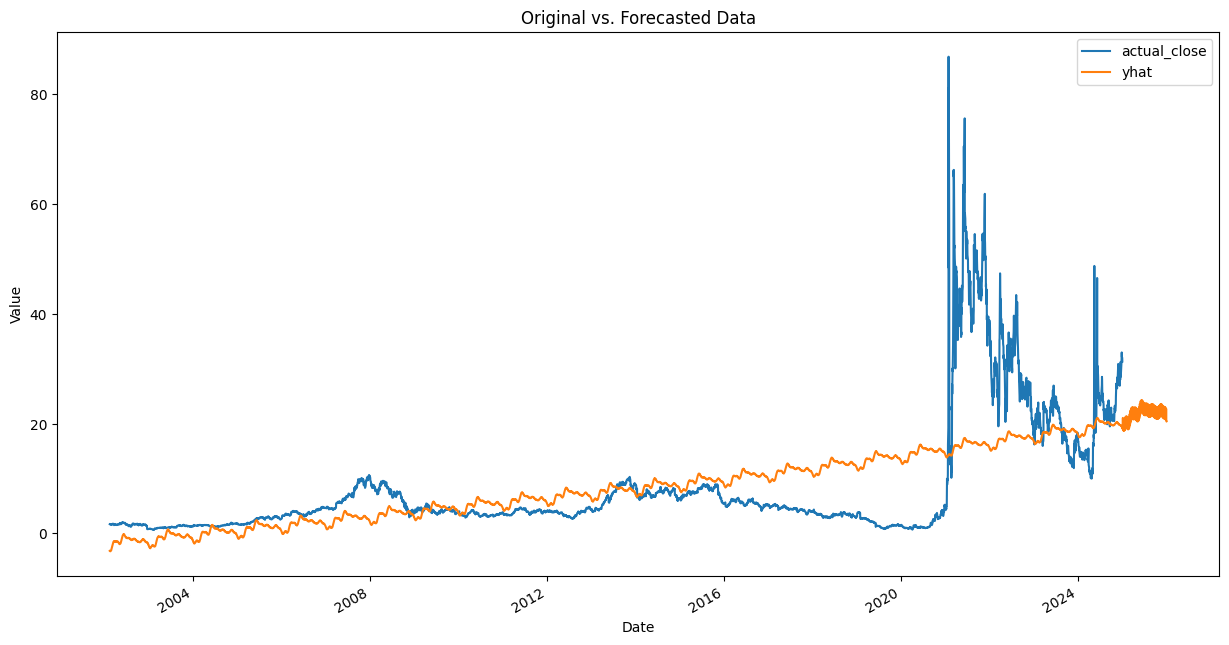

In [25]:
# Define the desired date range
start_date = date(year=2002, month=1, day=1)
end_date = date(year=2025, month=12, day=31)

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Filter the DataFrame based on the date range
df_filtered = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]

fig, ax = plt.subplots(figsize=(15, 8))

# Plot 'y' and 'winsorized_data' on the same graph
df_filtered.plot(x='ds', y=['actual_close', 'yhat'], ax=ax)

# Customize the plot (optional)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original vs. Forecasted Data')
plt.legend()

# Show the plot
plt.show()

In [26]:
# visualize

# Plot Forecast
fig1 = plot_plotly(m, forecast)
# fig1.layout.update(title_text=f"Forecast for 1 Year: {ticker_name} '{selected_stock}'")
fig1.update_layout(yaxis_title='Price')
fig1.update_layout(xaxis_title='Date')
# ADD LEGEND <<<<<
# Calculate default date range
end_date = forecast['ds'].max()
start_date = end_date - pd.Timedelta(days=1095)
fig1.update_xaxes(range=[start_date, end_date])
# fig1.update_layout(xaxis_rangeslider_visible=False)
fig1

### follow up
* gme mape results are 7.97% better with winsorization than just grid search and cross-validation! (0.310355 vs 0.390088)
    * winsorized model is 25.95% better mape than un-tuned model (0.310355 vs 0.569809)
    * however, it looks like the model itself doesn't really match well with the actual data. I want both, or more so graphically if i have to choose. 

* figure out what performance_metrics() does to calculate metrics. it is wildly different than get_model_accuracy()
    * get_model_accuracy() measures the error outside of the forecast
    * performance_metrics() measures error from cross-validation

* why is the model just a straight line? like obviously theres a pattern but it doesn't match well with actual price. or is it just GME?
    * let's fiddle w some parameters for GME, it seems like there's no changepoints

* have code evaluate given dataset (for volitility?) and put out the best model for that data

### -- Next --
* tune changepoint_prior_scale
    * Typical Values: 0.001 to 0.5
* tune fourier_order
    * Typical Values: 0.1 to 10
* tune fourier_order
    * Typical Values: 3 to 10 (for yearly seasonality)
* n_changepoints
    *  Typical Values: 20-50 for typical time series

In [ ]:
%%time
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Define hyperparameter grid
param_grid = {
    'seasonality_mode': ['multiplicative', 'additive'],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5, 1], 
    'seasonality_prior_scale': [0.1, 1, 10, 15, 20],
    'fourier_order': [3, 5, 7],
    'n_changepoints': [20, 30, 40]
}

best_params = None
best_score = float('inf') 

for seasonality_mode in param_grid['seasonality_mode']:
    for changepoint_prior_scale in param_grid['changepoint_prior_scale']:
        for seasonality_prior_scale in param_grid['seasonality_prior_scale']:
            for fourier_order in param_grid['fourier_order']:
                for n_changepoints in param_grid['n_changepoints']:
                    # Create and fit the model
                    m = Prophet(
                        seasonality_mode=seasonality_mode,
                        changepoint_prior_scale=changepoint_prior_scale,
                        seasonality_prior_scale=seasonality_prior_scale,
                        fourier_order=fourier_order,
                        n_changepoints=n_changepoints
                    )
                m.fit(df_train)
                df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days') 
                df_p = performance_metrics(df_cv)
                score = df_p['rmse'].mean() 

                if score < best_score:
                    best_score = score
                    best_params = {
                        'seasonality_mode': seasonality_mode,
                        'changepoint_prior_scale': changepoint_prior_scale,
                        'seasonality_prior_scale': seasonality_prior_scale,
                        'fourier_order'=fourier_order,
                        'n_changepoints'=n_changepoints
                                }

17:58:55 - cmdstanpy - INFO - Chain [1] start processing
17:58:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/41 [00:00<?, ?it/s]

17:58:56 - cmdstanpy - INFO - Chain [1] start processing
17:58:56 - cmdstanpy - INFO - Chain [1] done processing
17:58:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:56 - cmdstanpy - INFO - Chain [1] start processing
17:58:57 - cmdstanpy - INFO - Chain [1] done processing
17:58:57 - cmdstanpy - INFO - Chain [1] start processing
17:58:57 - cmdstanpy - INFO - Chain [1] done processing
17:58:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:57 - cmdstanpy - INFO - Chain [1] start processing
17:58:58 - cmdstanpy - INFO - Chain [1] done processing
17:58:58 - cmdstanpy - INFO - Chain [1] start processing
17:58:58 - cmdstanpy - INFO - Chain [1] done processing
17:58:58 - cmdstanpy - INFO - Chain [1] start processing
17:58:58 - cmdstanpy - INFO - Chain [1] done processing
17:58:58 -

  0%|          | 0/41 [00:00<?, ?it/s]

17:59:12 - cmdstanpy - INFO - Chain [1] start processing
17:59:12 - cmdstanpy - INFO - Chain [1] done processing
17:59:12 - cmdstanpy - INFO - Chain [1] start processing
17:59:12 - cmdstanpy - INFO - Chain [1] done processing
17:59:12 - cmdstanpy - INFO - Chain [1] start processing
17:59:12 - cmdstanpy - INFO - Chain [1] done processing
17:59:12 - cmdstanpy - INFO - Chain [1] start processing
17:59:12 - cmdstanpy - INFO - Chain [1] done processing
17:59:12 - cmdstanpy - INFO - Chain [1] start processing
17:59:13 - cmdstanpy - INFO - Chain [1] done processing
17:59:13 - cmdstanpy - INFO - Chain [1] start processing
17:59:13 - cmdstanpy - INFO - Chain [1] done processing
17:59:13 - cmdstanpy - INFO - Chain [1] start processing
17:59:13 - cmdstanpy - INFO - Chain [1] done processing
17:59:13 - cmdstanpy - INFO - Chain [1] start processing
17:59:14 - cmdstanpy - INFO - Chain [1] done processing
17:59:14 - cmdstanpy - INFO - Chain [1] start processing
17:59:15 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/41 [00:00<?, ?it/s]

18:00:21 - cmdstanpy - INFO - Chain [1] start processing
18:00:22 - cmdstanpy - INFO - Chain [1] done processing
18:00:22 - cmdstanpy - INFO - Chain [1] start processing
18:00:23 - cmdstanpy - INFO - Chain [1] done processing
18:00:23 - cmdstanpy - INFO - Chain [1] start processing
18:00:24 - cmdstanpy - INFO - Chain [1] done processing
18:00:24 - cmdstanpy - INFO - Chain [1] start processing
18:00:25 - cmdstanpy - INFO - Chain [1] done processing
18:00:25 - cmdstanpy - INFO - Chain [1] start processing
18:00:25 - cmdstanpy - INFO - Chain [1] done processing
18:00:25 - cmdstanpy - INFO - Chain [1] start processing
18:00:27 - cmdstanpy - INFO - Chain [1] done processing
18:00:27 - cmdstanpy - INFO - Chain [1] start processing
18:00:28 - cmdstanpy - INFO - Chain [1] done processing
18:00:28 - cmdstanpy - INFO - Chain [1] start processing
18:00:29 - cmdstanpy - INFO - Chain [1] done processing
18:00:29 - cmdstanpy - INFO - Chain [1] start processing
18:00:30 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/41 [00:00<?, ?it/s]

18:01:41 - cmdstanpy - INFO - Chain [1] start processing
18:01:41 - cmdstanpy - INFO - Chain [1] done processing
18:01:41 - cmdstanpy - INFO - Chain [1] start processing
18:01:42 - cmdstanpy - INFO - Chain [1] done processing
18:01:42 - cmdstanpy - INFO - Chain [1] start processing
18:01:43 - cmdstanpy - INFO - Chain [1] done processing
18:01:43 - cmdstanpy - INFO - Chain [1] start processing
18:01:44 - cmdstanpy - INFO - Chain [1] done processing
18:01:44 - cmdstanpy - INFO - Chain [1] start processing
18:01:45 - cmdstanpy - INFO - Chain [1] done processing
18:01:45 - cmdstanpy - INFO - Chain [1] start processing
18:01:46 - cmdstanpy - INFO - Chain [1] done processing
18:01:46 - cmdstanpy - INFO - Chain [1] start processing
18:01:47 - cmdstanpy - INFO - Chain [1] done processing
18:01:47 - cmdstanpy - INFO - Chain [1] start processing
18:01:47 - cmdstanpy - INFO - Chain [1] done processing
18:01:47 - cmdstanpy - INFO - Chain [1] start processing
18:01:48 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/41 [00:00<?, ?it/s]

18:02:44 - cmdstanpy - INFO - Chain [1] start processing
18:02:44 - cmdstanpy - INFO - Chain [1] done processing
18:02:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:02:44 - cmdstanpy - INFO - Chain [1] start processing
18:02:45 - cmdstanpy - INFO - Chain [1] done processing
18:02:45 - cmdstanpy - INFO - Chain [1] start processing
18:02:45 - cmdstanpy - INFO - Chain [1] done processing
18:02:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:02:45 - cmdstanpy - INFO - Chain [1] start processing
18:02:46 - cmdstanpy - INFO - Chain [1] done processing
18:02:46 - cmdstanpy - INFO - Chain [1] start processing
18:02:46 - cmdstanpy - INFO - Chain [1] done processing
18:02:46 - cmdstanpy - INFO - Chain [1] start processing
18:02:46 - cmdstanpy - INFO - Chain [1] done processing
18:02:46 -

  0%|          | 0/41 [00:00<?, ?it/s]

18:03:00 - cmdstanpy - INFO - Chain [1] start processing
18:03:00 - cmdstanpy - INFO - Chain [1] done processing
18:03:00 - cmdstanpy - INFO - Chain [1] start processing
18:03:00 - cmdstanpy - INFO - Chain [1] done processing
18:03:00 - cmdstanpy - INFO - Chain [1] start processing
18:03:00 - cmdstanpy - INFO - Chain [1] done processing
18:03:00 - cmdstanpy - INFO - Chain [1] start processing
18:03:00 - cmdstanpy - INFO - Chain [1] done processing
18:03:00 - cmdstanpy - INFO - Chain [1] start processing
18:03:00 - cmdstanpy - INFO - Chain [1] done processing
18:03:01 - cmdstanpy - INFO - Chain [1] start processing
18:03:01 - cmdstanpy - INFO - Chain [1] done processing
18:03:01 - cmdstanpy - INFO - Chain [1] start processing
18:03:01 - cmdstanpy - INFO - Chain [1] done processing
18:03:01 - cmdstanpy - INFO - Chain [1] start processing
18:03:01 - cmdstanpy - INFO - Chain [1] done processing
18:03:01 - cmdstanpy - INFO - Chain [1] start processing
18:03:01 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/41 [00:00<?, ?it/s]

18:03:18 - cmdstanpy - INFO - Chain [1] start processing
18:03:18 - cmdstanpy - INFO - Chain [1] done processing
18:03:18 - cmdstanpy - INFO - Chain [1] start processing
18:03:18 - cmdstanpy - INFO - Chain [1] done processing
18:03:18 - cmdstanpy - INFO - Chain [1] start processing
18:03:18 - cmdstanpy - INFO - Chain [1] done processing
18:03:18 - cmdstanpy - INFO - Chain [1] start processing
18:03:19 - cmdstanpy - INFO - Chain [1] done processing
18:03:19 - cmdstanpy - INFO - Chain [1] start processing
18:03:19 - cmdstanpy - INFO - Chain [1] done processing
18:03:19 - cmdstanpy - INFO - Chain [1] start processing
18:03:19 - cmdstanpy - INFO - Chain [1] done processing
18:03:19 - cmdstanpy - INFO - Chain [1] start processing
18:03:20 - cmdstanpy - INFO - Chain [1] done processing
18:03:20 - cmdstanpy - INFO - Chain [1] start processing
18:03:20 - cmdstanpy - INFO - Chain [1] done processing
18:03:20 - cmdstanpy - INFO - Chain [1] start processing
18:03:21 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/41 [00:00<?, ?it/s]

18:03:54 - cmdstanpy - INFO - Chain [1] start processing
18:03:55 - cmdstanpy - INFO - Chain [1] done processing
18:03:55 - cmdstanpy - INFO - Chain [1] start processing
18:03:55 - cmdstanpy - INFO - Chain [1] done processing
18:03:55 - cmdstanpy - INFO - Chain [1] start processing
18:03:55 - cmdstanpy - INFO - Chain [1] done processing
18:03:55 - cmdstanpy - INFO - Chain [1] start processing
18:03:56 - cmdstanpy - INFO - Chain [1] done processing
18:03:56 - cmdstanpy - INFO - Chain [1] start processing
18:03:56 - cmdstanpy - INFO - Chain [1] done processing
18:03:56 - cmdstanpy - INFO - Chain [1] start processing
18:03:57 - cmdstanpy - INFO - Chain [1] done processing
18:03:57 - cmdstanpy - INFO - Chain [1] start processing
18:03:57 - cmdstanpy - INFO - Chain [1] done processing
18:03:57 - cmdstanpy - INFO - Chain [1] start processing
18:03:58 - cmdstanpy - INFO - Chain [1] done processing
18:03:58 - cmdstanpy - INFO - Chain [1] start processing
18:03:59 - cmdstanpy - INFO - Chain [1]

CPU times: user 43.6 s, sys: 4.95 s, total: 48.6 s
Wall time: 5min 39s


In [ ]:
# Train the final model with the best hyperparameters
final_model = Prophet(**best_params)
final_model.fit(df_train)

18:04:35 - cmdstanpy - INFO - Chain [1] start processing
18:04:35 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
best_params

{'seasonality_mode': 'additive',
 'changepoint_prior_scale': 0.001,
 'seasonality_prior_scale': 10}

In [ ]:
%%time
df_cv = cross_validation(final_model, initial='730 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv)

  0%|          | 0/41 [00:00<?, ?it/s]

18:04:35 - cmdstanpy - INFO - Chain [1] start processing
18:04:35 - cmdstanpy - INFO - Chain [1] done processing
18:04:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:04:35 - cmdstanpy - INFO - Chain [1] start processing
18:04:36 - cmdstanpy - INFO - Chain [1] done processing
18:04:36 - cmdstanpy - INFO - Chain [1] start processing
18:04:36 - cmdstanpy - INFO - Chain [1] done processing
18:04:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:04:36 - cmdstanpy - INFO - Chain [1] start processing
18:04:37 - cmdstanpy - INFO - Chain [1] done processing
18:04:37 - cmdstanpy - INFO - Chain [1] start processing
18:04:37 - cmdstanpy - INFO - Chain [1] done processing
18:04:37 - cmdstanpy - INFO - Chain [1] start processing
18:04:37 - cmdstanpy - INFO - Chain [1] done processing
18:04:37 -

CPU times: user 5.31 s, sys: 576 ms, total: 5.89 s
Wall time: 15.2 s


In [ ]:
print(df_p.mean())

horizon     200 days 12:00:00
mse                 101.86065
rmse                10.058556
mae                  5.049657
mape                 0.749817
mdape                0.468528
smape                0.551612
coverage             0.369359
dtype: object


In [ ]:
future = final_model.make_future_dataframe(periods=period)
forecast = final_model.predict(future)

In [ ]:
get_model_accuracy(df_train.Close, forecast)

,Mean Absolute Error,Mean Absolute Percentage Error,Mean Squared Error,Root Mean Squared Error
0,5.053933,0.310358,39.640326,6.296056


In [ ]:
forecast['actual_close'] = df.Close

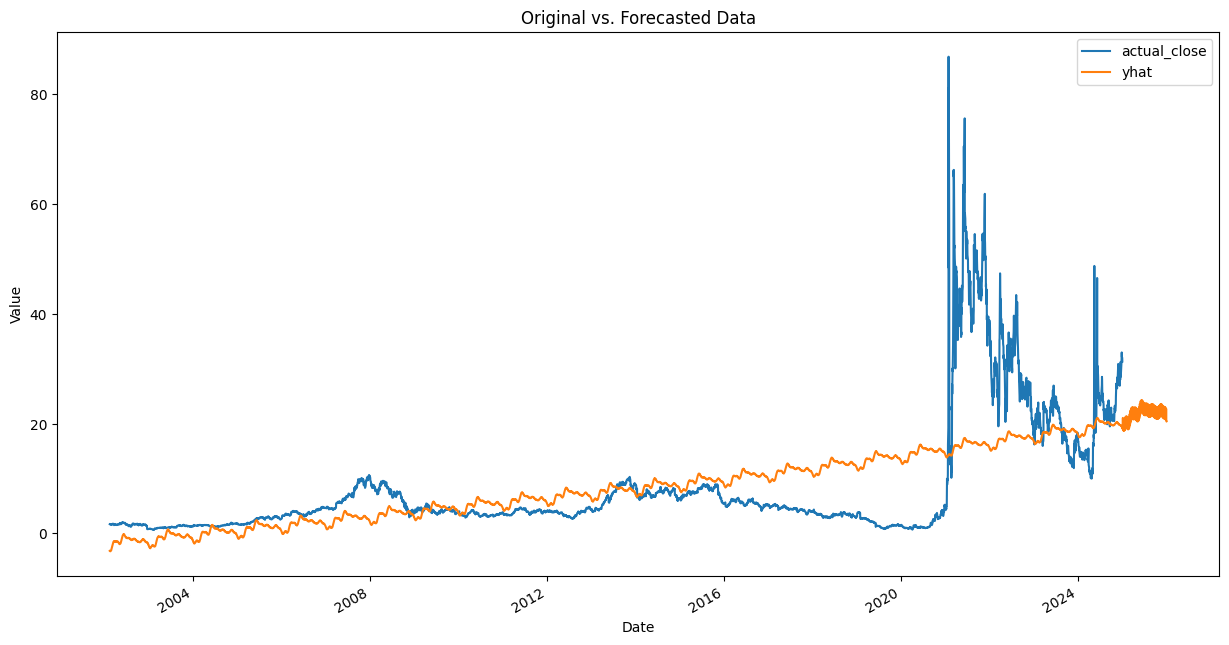

In [ ]:
# Define the desired date range
start_date = date(year=2002, month=1, day=1)
end_date = date(year=2025, month=12, day=31)

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Filter the DataFrame based on the date range
df_filtered = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]

fig, ax = plt.subplots(figsize=(15, 8))

# Plot 'y' and 'winsorized_data' on the same graph
df_filtered.plot(x='ds', y=['actual_close', 'yhat'], ax=ax)

# Customize the plot (optional)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original vs. Forecasted Data')
plt.legend()

# Show the plot
plt.show()

In [ ]:
# visualize

# Plot Forecast
fig1 = plot_plotly(m, forecast)
# fig1.layout.update(title_text=f"Forecast for 1 Year: {ticker_name} '{selected_stock}'")
fig1.update_layout(yaxis_title='Price')
fig1.update_layout(xaxis_title='Date')
# ADD LEGEND <<<<<
# Calculate default date range
end_date = forecast['ds'].max()
start_date = end_date - pd.Timedelta(days=1095)
fig1.update_xaxes(range=[start_date, end_date])
# fig1.update_layout(xaxis_rangeslider_visible=False)
fig1